In [1]:
import scipy

import os
import numpy as np
import cv2

import tensorflow as tf
import subprocess
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import tensorflow_probability as tfp

import xplique
from xplique.attributions import *
from xplique.metrics import *

from xplique_addons import *
from utils import *

from explanation.face_interpret import FaceHsicAttributionMethod

import onnx_tf.backend
import onnx

import torchvision.transforms.functional as TF
import torch.nn.functional as F

import numpy as np
from PIL import Image

from models_onnx.Attr_CelebA import AttributeModel

red_tr    = get_alpha_cmap('Reds')

2023-04-25 19:39:19.104916: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 19:39:19.145946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 19:39:19.836083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_6480/2268899326.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8

In [2]:
def interpolate(img, size):
    if type(size) == tuple:
        assert size[0] == size[1]
        size = size[0]

    orig_size = img.size(3)
    if size < orig_size:
        mode = 'area'
    else:
        mode = 'bilinear'
    return F.interpolate(img, (size, size), mode=mode)

def read_img(path):
    img = Image.open(path).convert('RGB')
    img = TF.to_tensor(img)
    img = img.unsqueeze(0)
    if img.size(-1) != 224:
        img = interpolate(img, 224)
    img = img.permute(0, 2, 3, 1)
    return img[0].numpy()

In [3]:
model_path = "ckpt/AttributeNet-CelebA.onnx"
tf_model = AttributeModel(model_path)

In [4]:
image_path= "image/n000004-0004_02.jpg"

In [31]:
def visualization_exist_attributes(tf_model, image_path, threshold=0.4):
    grid_size = 7
    nb_forward = 400
    
    X_raw = np.array([read_img(image_path)])
    tf_model.set_idx_list([
            'male', 'female', 'young', 'old',
            'arched_eyebrows', 'bushy_eyebrows',
            'mouth_slightly_open', 'big_lips',
            'big_nose', 'pointy_nose',
            'bags_under_eyes', 'narrow_eyes'
        ])
    
    predict = tf_model(X_raw, True)[0]
    predict = (predict > threshold).astype(int)

    attr = np.array(tf_model.facial_attribute)[np.argwhere(predict==1).flatten()]

    tf_model.set_idx_list(attr)

    labels = np.array([i for i in range(len(attr))])
    labels_ohe = tf.one_hot(labels, len(attr))
    
    Input = np.array([read_img(image_path) for i in attr])

    hsic_explainer = FaceHsicAttributionMethod(tf_model, 
                                        grid_size = grid_size, 
                                        nb_design = nb_forward , 
                                        sampler = HsicLHSSampler(binary=True), 
                                        estimator = HsicEstimator(kernel_type="binary"),
                                        perturbation_function = 'inpainting',
                                        batch_size = 128)
    
    explanations = hsic_explainer(Input, labels_ohe)
    explanations = np.array(explanations)

    plt.figure(figsize=(16,16))
    for i in range(len(attr)):
        ax = plt.subplot(1, len(attr), i+1)
        show(Input[i])
        show(explanations[i], cmap="jet", alpha=0.4)
        ax.set_title(attr[i])
    plt.show()

    return explanations

In [6]:
tf_model.set_idx_list([
            'male', 'female', 'young', 'old',
            'arched_eyebrows', 'bushy_eyebrows',
            'mouth_slightly_open', 'big_lips',
            'big_nose', 'pointy_nose',
            'bags_under_eyes', 'narrow_eyes'
        ])

In [7]:
X_raw = np.array([read_img(image_path)])

In [9]:
predict = tf_model(X_raw, True)

2023-04-25 19:58:24.887491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [400,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-25 19:58:25.785349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [400,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-25 19:58:26.647990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shap

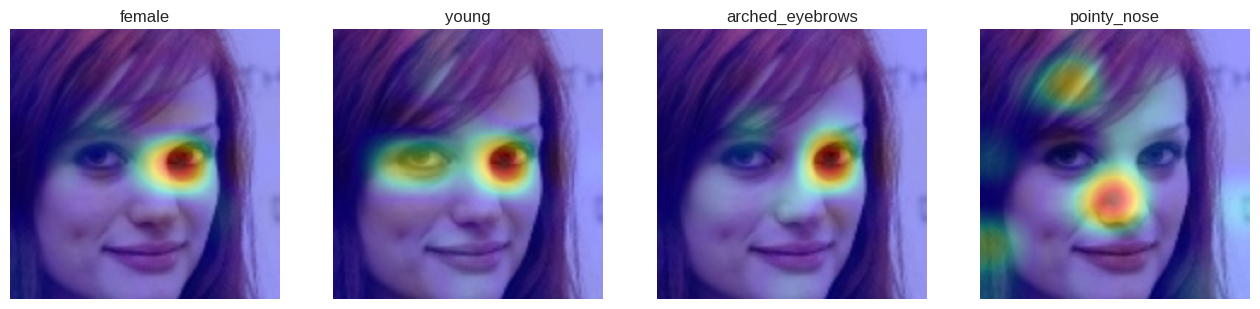

array([[[ 7.45880678e-02,  7.47364461e-02,  7.48572871e-02, ...,
          3.17909718e-02,  3.17105986e-02,  3.16118971e-02],
        [ 7.44032264e-02,  7.45499879e-02,  7.46695027e-02, ...,
          3.19278985e-02,  3.18463333e-02,  3.17461677e-02],
        [ 7.42527172e-02,  7.43981525e-02,  7.45165870e-02, ...,
          3.20394002e-02,  3.19568627e-02,  3.18555012e-02],
        ...,
        [ 1.70614064e-01,  1.71058938e-01,  1.71421140e-01, ...,
          3.36188525e-02,  3.35876197e-02,  3.35492715e-02],
        [ 1.70513391e-01,  1.70959026e-01,  1.71321869e-01, ...,
          3.35136689e-02,  3.34845893e-02,  3.34488750e-02],
        [ 1.70389771e-01,  1.70836344e-01,  1.71199962e-01, ...,
          3.33844945e-02,  3.33580524e-02,  3.33255827e-02]],

       [[ 2.75943486e-04,  2.77280807e-04,  2.78369727e-04, ...,
         -3.33613912e-06, -2.71955082e-06, -1.96232736e-06],
        [ 2.76380713e-04,  2.77724146e-04,  2.78818014e-04, ...,
         -4.81669122e-06, -4.19147545e

In [32]:
visualization_exist_attributes(tf_model, image_path= "image/n000002-0001_01.jpg", threshold=0.2)

2023-04-25 19:59:05.804658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [400,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-25 19:59:06.691823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [400,7,7,1]
	 [[{{node Placeholder/_0}}]]


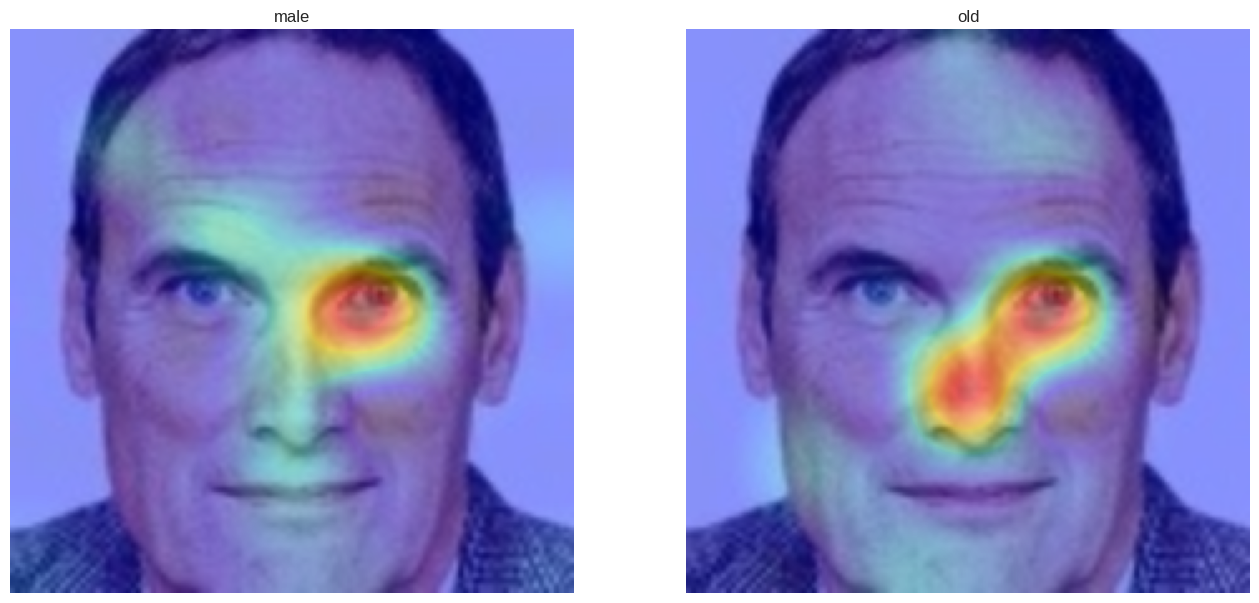

array([[[-1.85971567e-05,  7.05032144e-05,  1.43054873e-04, ...,
          9.18854959e-03,  9.18615516e-03,  9.18321405e-03],
        [-3.33917524e-05,  6.04055385e-05,  1.36781731e-04, ...,
          9.22176242e-03,  9.21937358e-03,  9.21643991e-03],
        [-4.54385554e-05,  5.21832917e-05,  1.31673703e-04, ...,
          9.24880803e-03,  9.24642384e-03,  9.24349576e-03],
        ...,
        [ 1.06310949e-01,  1.06773421e-01,  1.07149988e-01, ...,
          9.40274671e-02,  9.36812162e-02,  9.32559818e-02],
        [ 1.05922461e-01,  1.06383242e-01,  1.06758453e-01, ...,
          9.36764628e-02,  9.33315605e-02,  9.29079875e-02],
        [ 1.05445363e-01,  1.05904073e-01,  1.06277585e-01, ...,
          9.32453945e-02,  9.29021612e-02,  9.24806222e-02]],

       [[ 2.74777077e-02,  2.76114214e-02,  2.77202912e-02, ...,
          2.20033437e-01,  2.19492763e-01,  2.18828782e-01],
        [ 2.67467927e-02,  2.68797111e-02,  2.69879345e-02, ...,
          2.20832795e-01,  2.20286742e

In [34]:
visualization_exist_attributes(tf_model, image_path= "image/n000003-0002_01.jpg", threshold=0.3)

2023-04-25 19:59:17.319427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [400,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-25 19:59:18.195035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [400,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-25 19:59:19.069879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shap

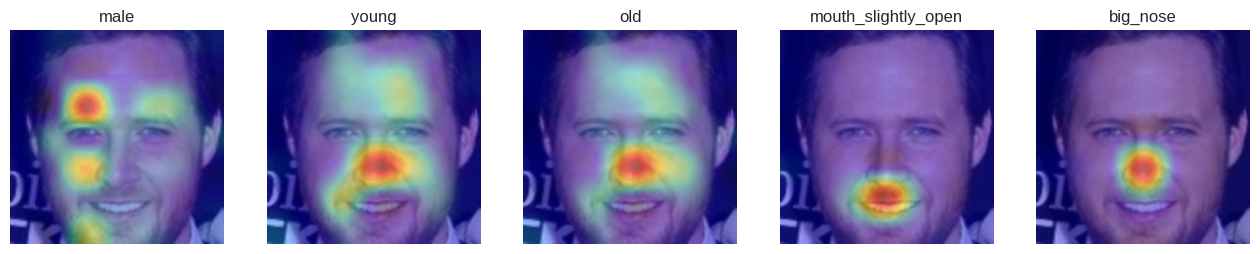

array([[[-0.00428707, -0.00452462, -0.00471805, ...,  0.03330048,
          0.03328198,  0.03325926],
        [-0.0042973 , -0.00453531, -0.00472911, ...,  0.03345906,
          0.03344008,  0.03341677],
        [-0.00430564, -0.00454401, -0.00473811, ...,  0.03358819,
          0.03356881,  0.03354502],
        ...,
        [ 0.00346781,  0.0034987 ,  0.00352386, ...,  0.03950444,
          0.03944585,  0.03937389],
        [ 0.00344048,  0.0034705 ,  0.00349495, ...,  0.03943571,
          0.03937726,  0.03930547],
        [ 0.0034069 ,  0.00343586,  0.00345945, ...,  0.0393513 ,
          0.03929302,  0.03922144]],

       [[-0.00113242, -0.00113803, -0.00114259, ..., -0.00136159,
         -0.00122273, -0.00105219],
        [-0.00122558, -0.00123127, -0.00123591, ..., -0.0014748 ,
         -0.00133495, -0.00116321],
        [-0.00130143, -0.0013072 , -0.0013119 , ..., -0.00156698,
         -0.00142634, -0.00125361],
        ...,
        [ 0.07058509,  0.07091213,  0.07117841, ...,  

In [35]:
visualization_exist_attributes(tf_model, image_path= "image/n000004-0004_02.jpg", threshold=0.2)

In [36]:
len(['blurry', 'sideburns', 'wearing_earrings', 'bald', 'goatee', 'mustache',
    '5_o_clock_shadow', 'arched_eyebrows', 'no_beard', 'heavy_makeup', 'male',
    'wearing_lipstick', 'black_hair', 'high_cheekbones', 'smiling',
    'mouth_slightly_open', 'oval_face', 'bushy_eyebrows', 'attractive',
    'young', 'gray_hair', 'brown_hair', 'blond_hair', 'pale_skin', 'chubby',
    'double_chin', 'big_nose', 'bags_under_eyes', 'wearing_necklace', 'wearing_necktie',
    'rosy_cheeks', 'bangs', 'wavy_hair', 'straight_hair', 'wearing_hat', 'big_lips',
    'narrow_eyes', 'pointy_nose', 'receding_hairline', 'eyeglasses'])

40